In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

In [2]:
cal_df = pd.read_csv('../input/m5-forecasting-accuracy/calendar.csv')
prices_df = pd.read_csv('../input/m5-forecasting-accuracy/sell_prices.csv')
sales_df_wide = pd.read_csv('../input/m5-forecasting-accuracy/sales_train_evaluation.csv')

## **Data Preprocessing**

In [3]:
#there are many NaN values in event_name and event_type fields
#Filling them with 'NoEvent' and 'None' resp
cal_df['event_name_1'].fillna('NoEvent',inplace=True)
cal_df['event_type_1'].fillna('None',inplace=True)
cal_df['event_name_2'].fillna('NoEvent',inplace=True)
cal_df['event_type_2'].fillna('None',inplace=True)
#dropping redundant columns and changing datatypes to reduce memory usage
cal_df.drop(['date','weekday'],axis=1,inplace=True)
cal_df['wm_yr_wk'] = cal_df.wm_yr_wk.astype('int16')
cal_df['d'] = cal_df.d.str[2:].astype('int16')
for col in ['event_name_1','event_type_1','event_name_2','event_type_2','snap_CA','snap_TX','snap_WI']:
  cal_df[col] = cal_df[col].astype('category')

In [4]:
# changing datatypes to reduce memory usage
prices_df['store_id'] = prices_df.store_id.astype('category')
prices_df['item_id'] = prices_df.item_id.astype('category')
prices_df['wm_yr_wk'] = prices_df.wm_yr_wk.astype('int16')
prices_df['sell_price'] = prices_df.sell_price.astype('float16')

In [5]:
#adding columns 'd_1942'...'d_1969' as we have to predict unit sales for these days and assigning value 0
for i in range(1942,1970):
    sales_df_wide['d_'+str(i)] = 0
#converting the wide-form data frame to long-form so that columns from other 2 data frames can be merged
train_df = pd.melt(sales_df_wide,id_vars=['id','item_id','dept_id','cat_id','store_id','state_id'],\
                   var_name='d',value_name='units_sold')
# changing datatypes to reduce memory usage
train_df['d'] = train_df.d.str[2:].astype('int16')
train_df['units_sold'] = train_df.units_sold.astype('int16')
for col in ['id','item_id','dept_id','cat_id','store_id','state_id']:
  train_df[col] = train_df[col].astype('category')    

In [6]:
#merging with 'cal_df'
train_df = pd.merge(train_df,cal_df,on='d',how='left')
#merging with 'prices_df'
train_df = pd.merge(train_df,prices_df,on=['item_id','store_id','wm_yr_wk'],how='left')

In [7]:
#sell_price data is not available for many rows. 
#For previous weeks filling this data by mean sell_prices for the item_id and store_id pair
train_df['sell_price'].fillna(train_df.groupby(['store_id','item_id'])['sell_price'].transform('mean'),inplace=True)

## **Exploratory Data Analysis**

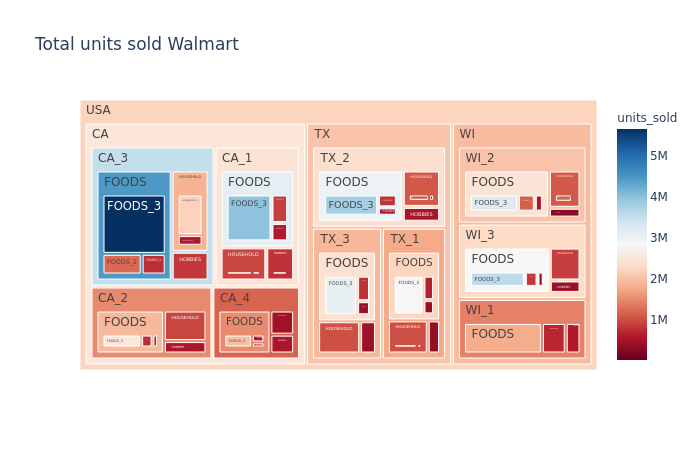

In [8]:
sales = train_df[~train_df['d'].isin(range(1942,1970))].\
        groupby(['state_id','store_id','cat_id','dept_id'],as_index=False)

sales = sales['units_sold'].sum()
#removing rows with 0 units_sold as getting zero division error and rows had wrong combination 
#e.g. state_id 'CA' and store_id 'TX_1'
sales = sales[sales['units_sold']!=0]
#adding 1 more level for the path
sales['USA'] = 'USA'
fig = px.treemap(sales,path=['USA','state_id','store_id','cat_id','dept_id'],
                 values='units_sold',color='units_sold',
                 color_continuous_scale = 'RdBu',
                 title = 'Total units sold Walmart')
fig.update_layout(treemapcolorway = ["pink", "lightgray"])
fig.show(renderer="png")

1. California has recorded highest sales followed by Texas and Wisconsin.
2. FOODS category has highest sales at all stores followed by HOUSEHOLD and HOBBIES has minimum sales.
3. At all stores FOODS_3 deparment in FOOD category has maximum sales followed by FOODS_2. FOODS_1 has minimum sales.
4. HOUSEHOLD_1 department has more sales thsan HOUSEHOLD_2.
5. HOBBIES_1 department has more sales than HOBBIES_2.

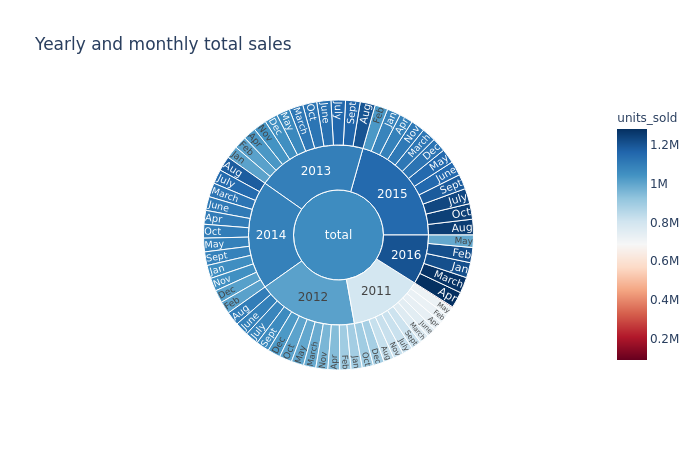

In [9]:
sales1 = train_df[~train_df['d'].isin(range(1942,1970))].groupby(['year','month'],as_index=False)
sales1 = sales1['units_sold'].sum()
#removing rows with 0 units_sold as getting zero division error and rows had wrong combination e.g. state_id 'CA' and store_id 'TX_1'
sales1 = sales1[sales1['units_sold']!=0]
sales1['total'] = 'total'
sales1['month'] = sales1.month.map({1:'Jan',2:'Feb',3:'March',4:'Apr',5:'May',6:'June',7:'July',8:'Aug',9:'Sept',10:'Oct',11:'Nov',12:'Dec'}) 
fig = px.sunburst(sales1, path = ['total','year', 'month'], values = 'units_sold',
                  color = 'units_sold',color_continuous_scale='RdBu',
                  title = 'Yearly and monthly total sales')
fig.show(renderer="png")

1. Total sales have steadily increased upto 2013. From 2013 to 2014 there was a slight drop in sales followed by a increase in 2015.
2. Total sales for 2016 are lowest as the sales data provided for 2016 is till June 19 only.
3. For 2011, January sales are very low as compared to other months. For rest of the months, sales are almost equal with some months recording slightly more sales and some slightly less.
4. For years 2012 to 2015, sales across months are almost constant with some slight highs and lows in sales. Also the 3rd quarter i.e. July-September have highest sales among all quarters.
5. 2016 sales for January to April are highest as comapred to previous year sales for these months.
6. March has recorded highest sales in 1st quarter of every year.

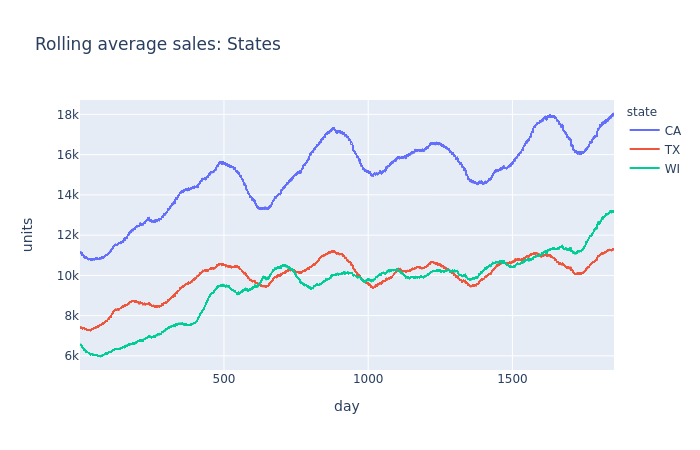

In [10]:
days = list(range(1,1853))
state_df = pd.DataFrame(columns=['day','units','state'])
for i in ['CA','TX','WI']:
    sales = train_df[(train_df['state_id']==i) & (~train_df['d'].isin(range(1942,1970)))]\
            .groupby(['d'])['units_sold'].sum().rolling(90).mean().dropna()
    temp = pd.DataFrame({'day':days,'units':sales,'state':i})
    state_df = pd.concat([state_df,temp])
fig = px.line(state_df,x = 'day', y = 'units', color = 'state',
              title = 'Rolling average sales: States')
fig.show(renderer="png")

1. California sales have constantly increased over the years
2. Texas sales are almost constant over the years
3. Wisconsin sales have a 2 sharp increases with sales being almost similar to Texas for most time period.

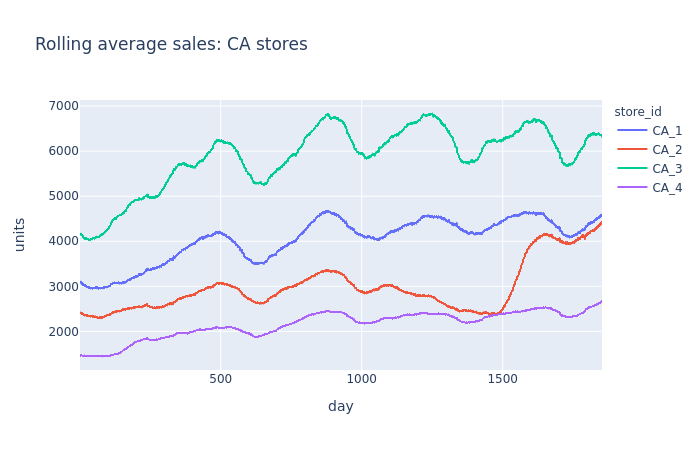

In [11]:
stores_ca_df = pd.DataFrame(columns=['day','units','store_id'])
for i in ['CA_1','CA_2','CA_3','CA_4']:
    sales = train_df[(train_df['store_id']==i) & (~train_df['d'].isin(range(1942,1970)))]\
            .groupby(['d'])['units_sold'].sum().rolling(90).mean().dropna()
    
    temp = pd.DataFrame({'day':days,'units':sales,'store_id':i})
    stores_ca_df = pd.concat([stores_ca_df,temp])
fig = px.line(stores_ca_df,x = 'day', y = 'units',color='store_id',
              title = 'Rolling average sales: CA stores')
fig.show(renderer="png")

1. No 2 stores in california have similar sales pattern.
2. Sales in CA_3 are maximum followed by CA_1 and CA_2. CA_4 sales are minimum. Difference in sales among stores can be becuase CA_3 being located in urban/faster growing area as compared to other stores.

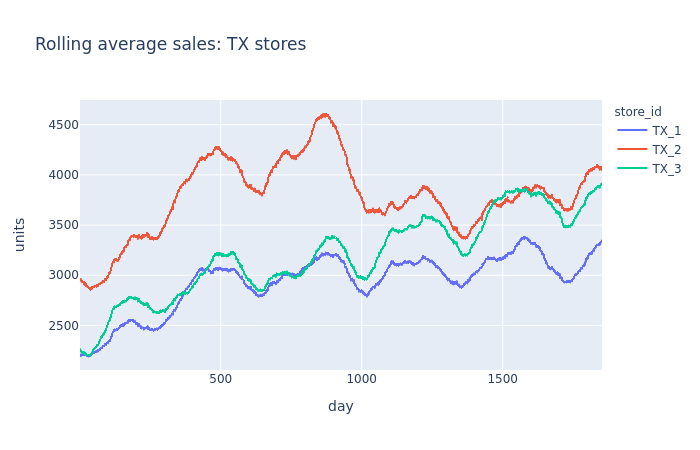

In [12]:
stores_tx_df = pd.DataFrame(columns=['day','units','store_id'])
for i in ['TX_1','TX_2','TX_3']:
    sales = train_df[(train_df['store_id']==i) & (~train_df['d'].isin(range(1942,1970)))]\
            .groupby(['d'])['units_sold'].sum().rolling(90).mean().dropna()
    
    temp = pd.DataFrame({'day':days,'units':sales,'store_id':i})
    stores_tx_df = pd.concat([stores_tx_df,temp])
fig = px.line(stores_tx_df,x = 'day', y = 'units',color='store_id',
              title = 'Rolling average sales: TX stores')
fig.show(renderer="png")

1. TX_2 initially had higher sales than other 2 stores.
2. TX_1 and TX_3 have almost similar sales pattern initially. Later TX_3 sales have increased and that of TX_2 decreased and these 2 have similar sales trends towards end.  


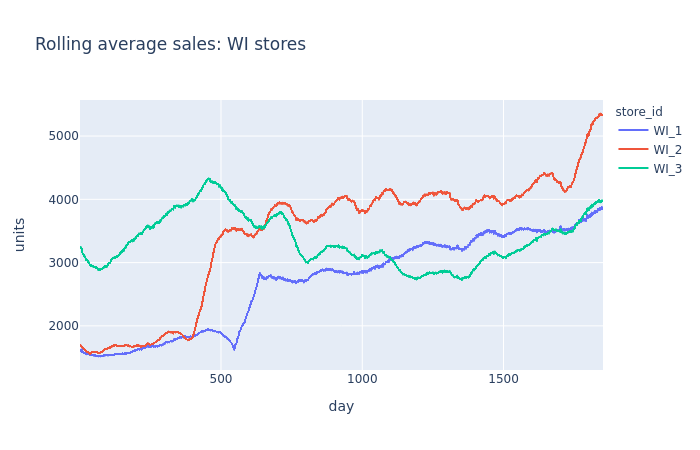

In [13]:
stores_wi_df = pd.DataFrame(columns=['day','units','store_id'])
for i in ['WI_1','WI_2','WI_3']:
    sales = train_df[(train_df['store_id']==i) & (~train_df['d'].isin(range(1942,1970)))]\
            .groupby(['d'])['units_sold'].sum().rolling(90).mean().dropna()
    
    temp = pd.DataFrame({'day':days,'units':sales,'store_id':i})
    stores_wi_df = pd.concat([stores_wi_df,temp])
fig = px.line(stores_wi_df,x = 'day', y = 'units',color='store_id',
              title = 'Rolling average sales: WI stores')
fig.show(renderer="png")

1. There is not much difference between sales patterns among Wisconsin stores indicating that they are located in equally popuplated areas/similar tier cities.

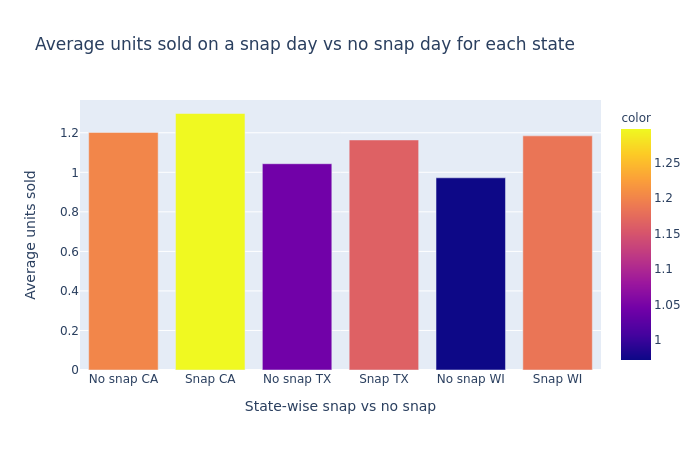

In [14]:
snap_ca_df = train_df[(train_df['state_id']=='CA') & (~train_df['d'].isin(range(1942,1970)))]
snap_tx_df = train_df[(train_df['state_id']=='TX') & (~train_df['d'].isin(range(1942,1970)))]
snap_wi_df = train_df[(train_df['state_id']=='WI') & (~train_df['d'].isin(range(1942,1970)))]
avgs = []
avgs.append(snap_ca_df.groupby(['snap_CA'])['units_sold'].mean()[0])
avgs.append(snap_ca_df.groupby(['snap_CA'])['units_sold'].mean()[1])
avgs.append(snap_tx_df.groupby(['snap_TX'])['units_sold'].mean()[0])
avgs.append(snap_tx_df.groupby(['snap_TX'])['units_sold'].mean()[1])
avgs.append(snap_wi_df.groupby(['snap_WI'])['units_sold'].mean()[0])
avgs.append(snap_wi_df.groupby(['snap_WI'])['units_sold'].mean()[1])

fig = px.bar(x=['No snap CA','Snap CA','No snap TX','Snap TX','No snap WI','Snap WI'], 
             y=avgs,color=avgs,
             labels={'x':'State-wise snap vs no snap','y':'Average units sold'},
             title = 'Average units sold on a snap day vs no snap day for each state')
fig.show(renderer="png")

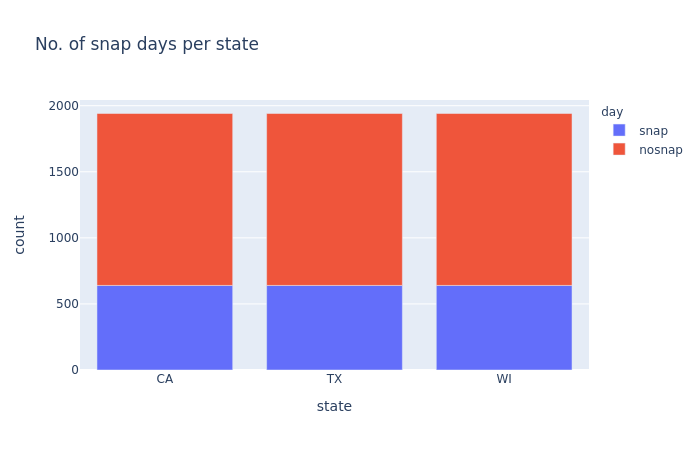

In [15]:
snap_days = []
nosnap_days = []

temp = snap_ca_df.drop_duplicates(subset=['d'])
snap_days.append(len(temp[temp['snap_CA']==1]))
nosnap_days.append(len(temp[temp['snap_CA']==0]))

temp = snap_tx_df.drop_duplicates(subset=['d'])
snap_days.append(len(temp[temp['snap_TX']==1]))
nosnap_days.append(len(temp[temp['snap_TX']==0]))

temp = snap_wi_df.drop_duplicates(subset=['d'])
snap_days.append(len(temp[temp['snap_WI']==1]))
nosnap_days.append(len(temp[temp['snap_WI']==0]))

c = []
c.extend(snap_days)
c.extend(nosnap_days)
snap_data = {'state':['CA','TX','WI','CA','TX','WI'],\
             'day':['snap','snap','snap','nosnap','nosnap','nosnap'],'count':c}
snap_df = pd.DataFrame(data=snap_data)

fig = px.bar(snap_df, x='state', y='count', color='day', title='No. of snap days per state')
fig.show(renderer="png")

1. Average daily units sold on a snap day is more than average daily units sold on a non snap day in all 3 states with the difference being highest in Wisconsin followed by Texas and California.
2. The low difference can be justified by the fact that there are about 67% non snap days as compared to 33% snap days in all 3 states.

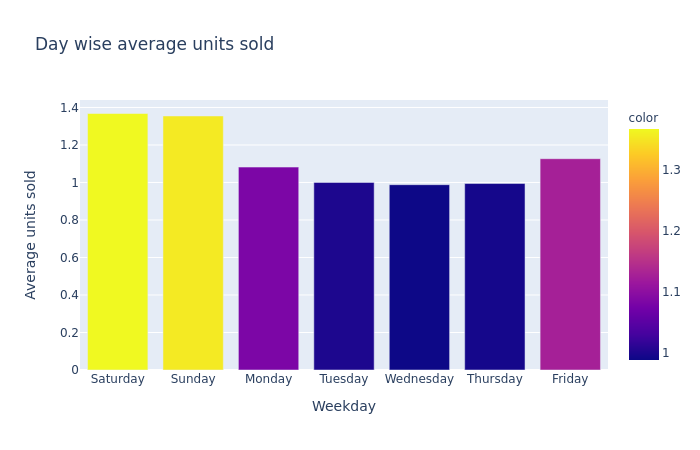

In [16]:
daily_mean = train_df[ ~train_df['d'].isin(range(1942,1970))]\
             .groupby('wday')['units_sold'].mean()

fig = px.bar(x=['Saturday','Sunday','Monday','Tuesday','Wednesday','Thursday','Friday'], 
                 y=daily_mean,color=daily_mean,
                 labels = {'x':'Weekday','y':'Average units sold'},
                 title = 'Day wise average units sold')
fig.show(renderer="png")

1. Average daily units sold have a weekly pattern with sales being highest on weekend - Saturday and Sunday.
2. The sales drop down during working days of the week and increase towards end of work week i.e Friday.

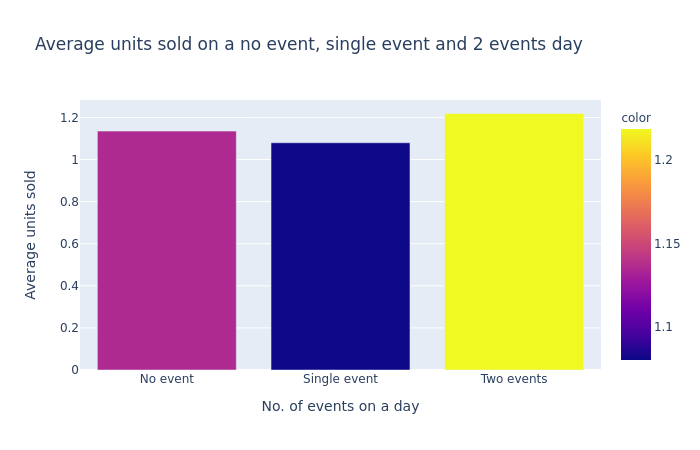

In [17]:
no_event = train_df[(train_df.event_type_1 == 'None') & (train_df.event_type_2 == 'None')\
            & ( ~train_df['d'].isin(range(1942,1970)))]

single_event = train_df[(((train_df.event_type_1 != 'None') \
              & (train_df.event_type_2 == 'None')) | ((train_df.event_type_1 == 'None') \
              & (train_df.event_type_2 != 'None'))) &  (~train_df['d'].isin(range(1942,1970)))]

two_events = train_df[(train_df.event_type_1 != 'None') & (train_df.event_type_2 != 'None') \
             & ( ~train_df['d'].isin(range(1942,1970)))]

event_type_avg = [no_event['units_sold'].mean(),single_event['units_sold'].mean(),\
                  two_events['units_sold'].mean()]

fig = px.bar(x = ['No event','Single event','Two events'], 
             y = event_type_avg,color=event_type_avg,
             labels = {'x':'No. of events on a day','y':'Average units sold'},
             title = 'Average units sold on a no event, single event and 2 events day')
fig.show(renderer="png")

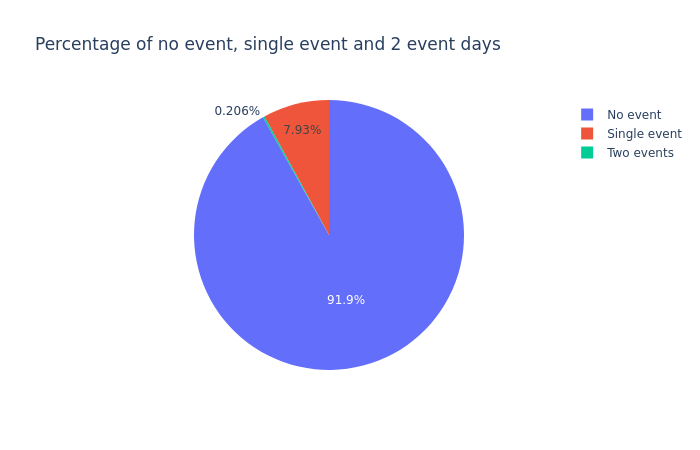

In [18]:
event_data = {'event_type':['No event','Single event','Two events'],\
              'days':[len(no_event.drop_duplicates(subset=['d'])),\
                      len(single_event.drop_duplicates(subset=['d'])),\
                      len(two_events.drop_duplicates(subset=['d']))]}

events_df = pd.DataFrame(data=event_data)

fig = px.pie(events_df,values='days',names='event_type',title='Percentage of no event, single event and 2 event days')
fig.show(renderer="png")

1. Out of 1941 days, around 91.86% days have no special events. Only 7.94% of days have a single special event and only 0.2% of days have 2 special events.
2. Average daily units sold on a day with 2 special events is more than no event and a single event days.
3. Average daily units sold on a single event day is less than no event day although the difference is not much.

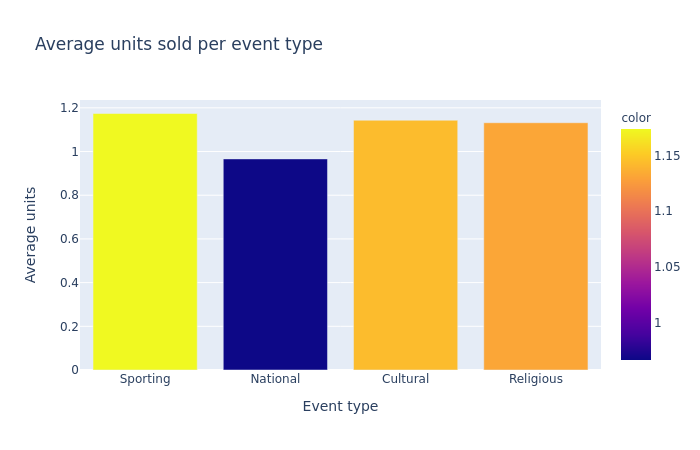

In [19]:
event_type = list(set(train_df.event_type_1.unique()) - set({'None'}))
total_units = []
for i in event_type:
    total_units.append(train_df[((train_df['event_type_1']==i) | (train_df['event_type_2']==i)) & (~train_df['d'].isin(range(1942,1970)))]['units_sold'].mean())

fig = px.bar(x = event_type, y = total_units, color = total_units,
             labels = {'x':'Event type','y':'Average units'},
             title = 'Average units sold per event type')
fig.show(renderer="png")

1. Sporting events have maximum average sales followed by Cultural and Religious. National events have minimum average sales. This can be as people like watching a game with their friends while snacking on their favorite food items. For cultural and religious events as well preparing special foods and decorating house is part of celebration.

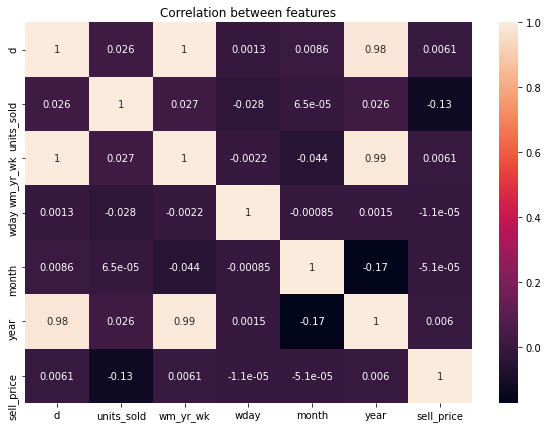

In [20]:
plt.figure(figsize=(10,7))
sns.heatmap(train_df.corr(), annot=True)
plt.title('Correlation between features')
plt.show()

1. 'wm_yr_wk' has highest correlation with target variable 'units_sold'.
2. 'wm_yr_wk','month' and 'd' are highly correlated so will consider only 1 of them.

## **EDA Conclusion**

1. There are no repetitive patterns in sales over time.
2. Category and Department have similar trends across all stores especially the departments. So 1 approach can be to train a model for each department.
3. Snap and special events hace higher average sales to normal days so they will be useful for prediction for those particualr days.